# Adaptive Cruise Control (ACC)

Safety is critical in autonomous driving. In this task, an optimization based safety-critical controller is designed that enables the vehicle to keep a safe distance to the leading vehicle while trying to reach the desired cruise velocity. 

The key of this problem is the tradeoff between the **safety** and **tracking** of desired velocity. 

## System model

Here, a point mass vehicle model is considered:

$$m \frac{dv}{dt} = F_w,$$

where $m$ is the mass, $v$ is the velocity of the vehicle, and $F_w$ is the traction force. For simplification, other resistances, such as aerodynamic drag are omitted. 

In the context of adaptive cruise control, let the velocity of leading vehicle be $v_0$. Thus, the distance between the two vehicle $D$ is governed by:

$$\frac{dD}{dt} = v_0 - v.$$ 

Then we have the dynamics of the system as:

$$
\frac{d}{dt}\begin{bmatrix} D\\ v \end{bmatrix} = \begin{bmatrix} v_0 - v \\ 0 \end{bmatrix} + \begin{bmatrix} 0\\ \frac{1}{m} \end{bmatrix} F_w.
$$

We assume $v_0$ is piecewise constant in this task. 

Now we introduce the constraints that need to be considered in the controller design.


<div>
<img src="assets/CBF_car2.png" width="500" align="left"/>
</div>


## Input constraints:

The traction and braking force can not exceed the allowable wheel forces:

$$-c_d g \le \frac{F_w}{m} \le c_a g,$$

where $g$ is the gravity, $c_d$ and $c_a$ are the coefficients that indicates the allowable braking and traction force. 


## Soft constraints:

We wish the vehicle to achieve the desired cruise velocity $v_d$:

$$(v - v_d)^2 \rightarrow 0.$$ 


## Hard constraints:


### Half-speedometer safety constraints
For ACC, we want to keep a safe distance from the leading vehicle.

We enforce the **half-speedometer** rule [6], such that the minimum distances between two vehicles to be half of the speedometer:

$$D \ge \frac{v}{2},$$ 

with $D$ in $m$ and $v$ in $km / hr$. For example, if the leading vehicle is traveling at $80km/hr$, the minimum distance should be $40m$.

When we convert the unit to $m$ and $m / s$, we have:

$$D \ge 1.8v.$$

### $T$-lookahead distance

To ensure safety while approaching the leading vehicle, we want the ego vehicle to always be able to maintain safe distance using the **maximal** braking force. Under maximum braking force, we have the dynamics of the vehicle starting at time $t$ as:

$$
v(t+\tau)=v(t)-\tau c_d g,
$$

and thus solving for $T$ such that $v(t+T)=v_0$ (following at the velocity of the lead vehicle) yields

$$
T=\frac{v_0-v(t)}{-c_d g} .
$$

Then integrating the dynamics of $D$ yields:

$$
\begin{aligned}
D(t+T) & =D(t)+\int_0^T\left[v_0-v(t+\tau)\right] d \tau \\
& =D(t)+\int_0^T\left[v_0-v(t)+\tau c_d g\right] d \tau \\
& =D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g}
\end{aligned}
$$

Hence, if the current headway is $D(t)$, the headway looking $T$ seconds ahead, which is based on decelerating at the maximum rate to a following speed of $v_0$, is bounded by

$$
D(t+T)=D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g}.
$$

Finally, we have the safety constraints that ensure the vehicle always maintain the half of the speedometer distance by applying the maximum braking forces:

$$
D(t+T) = D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g} \ge 1.8v(t).
$$

# Controller design

Our goal is to design a controller that satsify the safety constraints

$$D(t)-\frac{1}{2} \frac{\left[v_0-v(t)\right]^2}{c_d g} \ge 1.8v(t), \forall t > 0,$$

and let the velocity $v$ go as close to $v_d$ as possible within the control limit.


## Linear state feedback

To track the desired velocity, the linear feedback, such as Linear Quadratic Regulator (LQR), takes the form:

$F_w = -K(v - v_d)$, where $K \in \mathbb{R}_{+}$ is the gain that decide how fast you can regularize $(v - v_d)$ to 0. 

Now we define the tracking performance as the square of the tracking error, i.e. 

$$h = \frac{(v - v_d)^2}{2}.$$

Then we take derivative of $h$ with respect to time, 

$$
\begin{equation}
\begin{aligned}

\dot{h} &= \frac{\partial h}{\partial v} \frac{dv}{dt} \\
        &= 0 + (v - v_d) \frac{F_w}{m} \\
        &= - \frac{K(v - v_d)^2}{m} \\
        &= -\frac{2K}{m}h

\end{aligned}
\end{equation}
$$

Thus, solving the above Ordinary Differential Equation (ODE), we have:

$$h(t) = \exp{(-\frac{2K}{m} t)} h(0),$$ 

with $h(0) = \frac{1}{2}(v(0) - v_d)^2$, which guarantees $(v - v_d)^2 \rightarrow 0$, as $t \rightarrow \infty$. 

## Tracking constraint as inequality

To allow the tradeoff for safety constraints, we replace the state feedback by inequality constraints on the tracking error:

Instead of Find $F_w$ to ensure $$\dot{h} = -\lambda h, $$

we only try to find $F_w$ to make $$\dot{h} \le -\lambda h, \text{ for some } \lambda > 0.$$

<!-- we can bound the value of $h$ by manipulating its change rate with respect to time. -->

<!-- By the comparison lemma[4], for a scalar function $h_1(t)$, if there exist another function $h_2(t)$, such that the time derivative $\dot{h}_1(t) \le \dot{h}_2(t)$ and initial value $h_1(0) \le h_2(0)$, we have $0 < h_1(t) \le h_2(t), \forall t$. -->

By the comparison lemma[4], if we can find such $F_w$ for $\forall t\ge 0$, there is an upper bound on the convergence rate of the tracking error:

$${h}(t) \le \exp{(-\lambda t)} h(0),$$

given the initial condition that $h(0)\ge 0 $. 

In this case, the upper bound of the tracking error is bounded by ${h}(t) = \exp{(-\lambda t)} h(0)$, which corresponds to a linear state feedback. 

## Safety constraints

Similar to the tracking performance, we define the barrier function to indicate the safety 

$$B:= D-\frac{1}{2} \frac{\left[v_0-v\right]^2}{c_d g} - 1.8v.$$

Where $B > 0$ indicate strict satisfaction of the safety constraints. 

If we can find $F_w$ to make $\dot{B} \ge -\alpha B$, with $\alpha > 0$,

we have the lower bounds on barrier function if $\exist F_w, \forall t$:

$$
B(t) \ge \exp{(-\alpha t) B(0)} \ge 0, B(0) \ge 0.
$$

## Quadratic programming (QP)-based minimum norm controller

If we substitute the dynamics of the vehicle to the above two inequality constraints on $h$ and $B$, we have:

$$
\dot{h} =  \frac{(v - v_d)}{m}F_w \le -\lambda h
$$

$$
\begin{equation}
\begin{aligned}
    \dot{B} =& \frac{d D}{d t} - \frac{d \frac{\left[v_0-v\right]^2}{2c_d g} + 1.8v}{d v}\frac{d v}{d t} \\
            =& (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B
\end{aligned}
\end{equation}
$$

Thus, a straight forward idea to bridge the **safety** and **tracking** performance is to design a controller that generate the smllest control input while satisfying the two inequality constraints:

$$
\begin{equation}
    \begin{aligned}
    \min_{F_w} & \quad F_w^2 \\ 
    \text{s.t. } & \frac{(v - v_d)}{m}F_w \le -\lambda h, \\
                 & (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B, \\
                 & -c_d g \le \frac{F_w}{m} \le c_a g.
    \end{aligned}
\end{equation}
$$

By solving this QP, we are able to find the minimal-norm control input within the control limits, while trying to converge to the desired velocity, and keep the safe distance.

### Tackling infeasibility

However, the two inequality may result in empty feasible set for the QP. For example, if the velocity of the leading vehicle is slower than the desired velocity, there is no control input that can enable the velocity converge to the desired one without sacrificing safety.

To solve the problem, we introduce a slack variable $\delta$ that allowing violation of the constraints for velocity tracking. While the safety is the priority, which should be always satisfied:

$$
\begin{equation}
    \begin{aligned}
    \min_{F_w, \delta} & \quad F_w^2 +  {w \delta^2} \\ 
    \text{s.t. } & \frac{(v - v_d)}{m}F_w \le -\lambda h + \delta, \\
                 & (v_0 - v) - \frac{1}{m}(1.8 + \frac{v - v_0}{c_dg}) F_w \ge -\alpha B, \\
                 & -c_d g \le \frac{F_w}{m} \le c_a g, \\
                 & \delta \ge 0.
    \end{aligned}
\end{equation}
$$

where $w$ is a large weight that penalize the slack variable.

## Approve to solve:

For this problem, we'll use the slacked QP-based minimal norm controller, where these matrices would be the key-> $P, q, A$ and $b$. 

Moreover, the performance of the controller will depend on the tuneed values of the parameters $\lambda$ for tracking, $\alpha$ for safety constraints and $w$ for the weight of slack variable.

$$
\begin{equation}
    \begin{aligned}
    \min_{x} & \quad \frac{1}{2}x^{T}Px + q^{T}x \\ 
    \text{s.t. } & Ax\le b
    \end{aligned}
\end{equation}
$$

Note: $x:= [F_w, \delta]$ and $A \in \mathbb{R}^{5\times 2}$. We will use the first variable produced by the QP solver as the control input. 

Keypoints: 

1. Larger $\lambda$ enables faster tracking of desired speed. 

2. Smaller $\alpha$ enables slower convergence to $B=0$. 

3. $w$ should be a large number.

4. Ensure the three number are in proper magnitute to make the QP feasible. 

## Requirement:

1. The safety constraints $B\ge 0$ is satisfied all time before the vehicle changes velocity.

2. The vehicle reaches the desired speed when it is allowed, e.g., before the leading vehicle changes its velocity or the leading vehicle's velocity is faster than the desired speed. 

3. No collision detected all the time. 

4. Input constraints are not violated. 

5. The QP is always feasible. 

## Remark:

The leading car will change its velocity at the swtich time shown in the **param**.

In [1]:
%load_ext autoreload
%autoreload 2
from controller_acc import *
from utils import *

In [10]:
param = {"vd": 15.0, "v0": 10.0, "m": 2000, "Cag": 0.3 * 9.81, "Cdg": 0.8 * 9.81, "v01": 5, "v02": 10, "switch_time": 30, "terminal_time": 50}
y0 = np.array([30, 20]) # [D(0), v(0)]
t, B, y, u = sim_vehicle(Controller, param, y0)

$v_{01}$ and $v_{02}$ are the leading car velocity before and after the switch time. 

$y_0:= [D(0), v(0)]$ is the initial state.

$v_d$ is the desired velocity.

We will test your controller with varying $v_d$, $v_{01}$, $v_{02}$ and $y_0$.

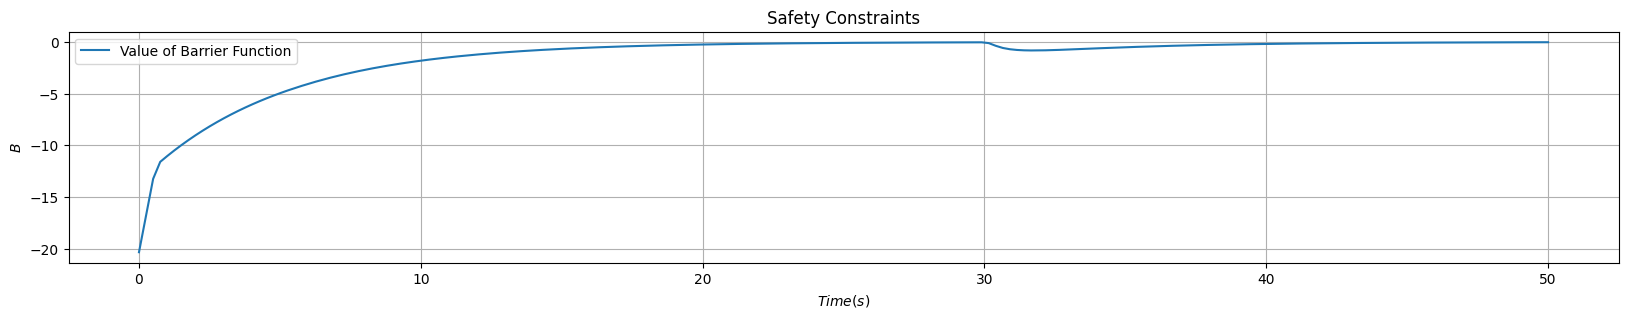

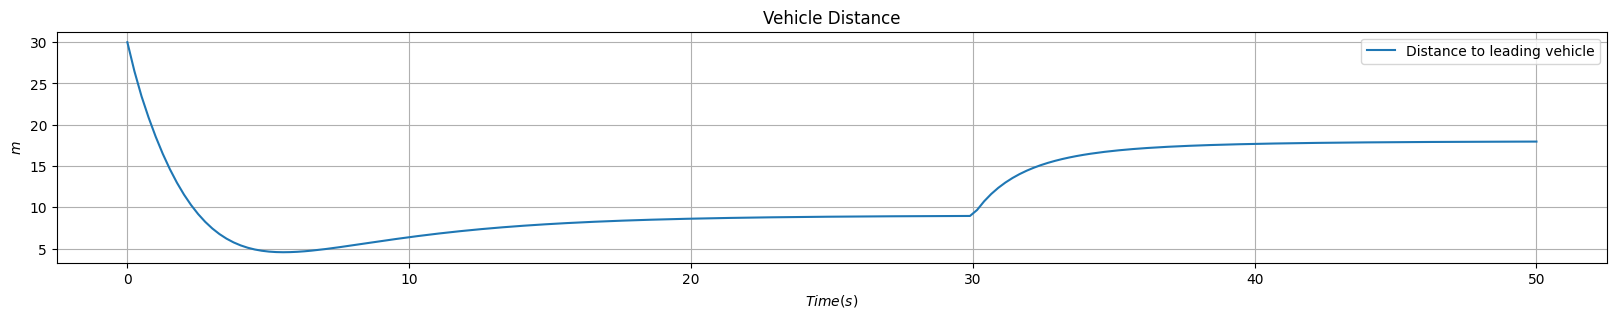

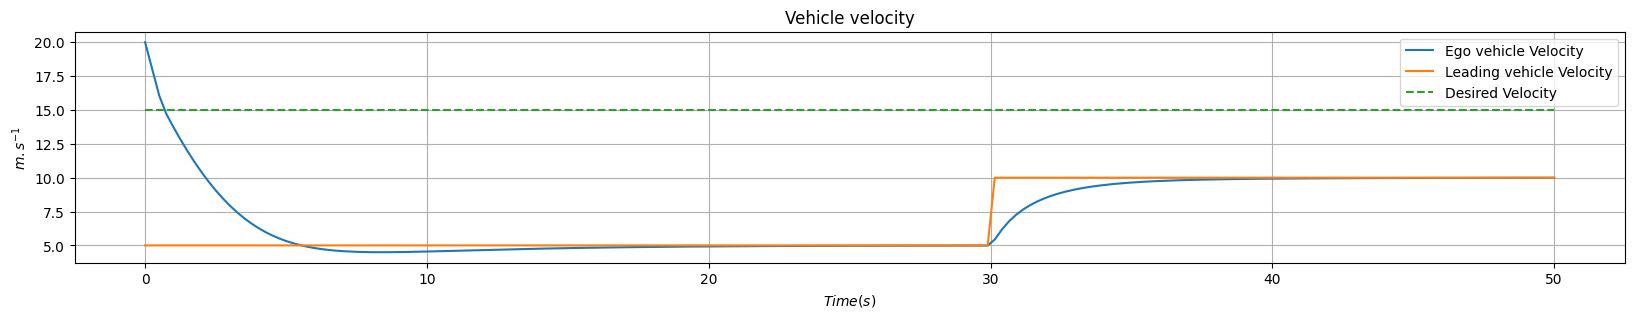

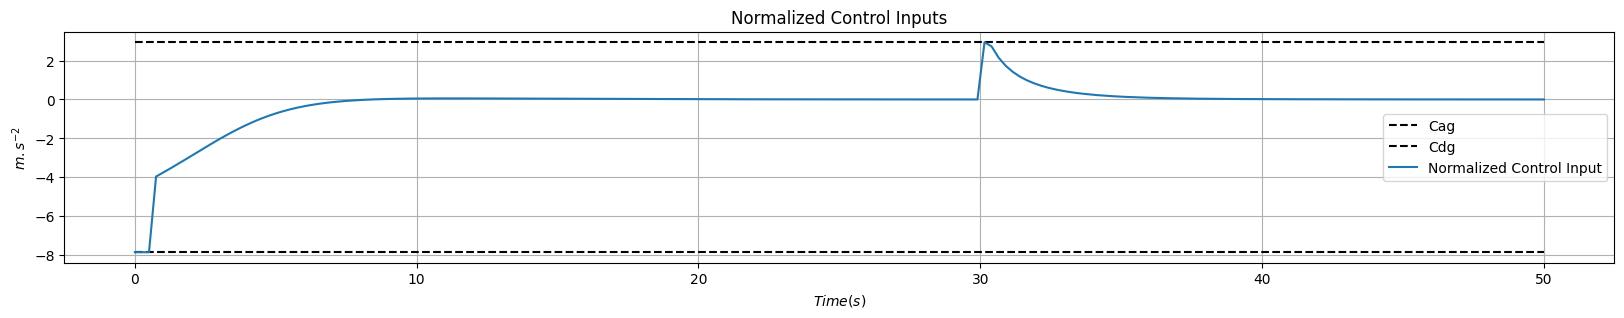

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.figure(figsize=(20, 3))
plt.plot(t, B, label="Value of Barrier Function")
plt.xlabel('$Time (s)$')
plt.ylabel('$B$')
plt.title('Safety Constraints')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(t, y[:, 0], label="Distance to leading vehicle")
plt.xlabel('$Time (s)$')
plt.ylabel('$m$')
plt.title('Vehicle Distance')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(20, 3))
plt.plot(t, y[:, 1], label="Ego vehicle Velocity")
v_lead = t * 0
v_lead[t <= param["switch_time"]] = param["v01"]
v_lead[t >= param["switch_time"]] = param["v02"]
plt.plot(t, v_lead, label="Leading vehicle Velocity")
plt.plot(t, t * 0 + param["vd"], "--", label="Desired Velocity")

plt.xlabel('$Time (s)$')
plt.ylabel('$m.s^{-1}$')
plt.title('Vehicle velocity')
plt.legend()
plt.grid()
plt.show()

data_to_save = np.column_stack((t, y[:, 0], y[:, 1], v_lead))
np.savetxt('velocity_data.txt', data_to_save, header='Time Distance Ego_vehicle_velocity Leading_vehicle_velocity', comments='')

plt.figure(figsize=(20, 3))
plt.plot(t, 0 * t - param["Cdg"], "k--", label="Cag")
plt.plot(t, 0 * t + param["Cag"], "k--", label="Cdg")
plt.plot(t, u / param["m"], label="Normalized Control Input")
plt.xlabel('$Time (s)$')
plt.ylabel('$m.s^{-2}$')
plt.title('Normalized Control Inputs')
plt.legend()
plt.grid()
plt.show()

## Now lets Animate the vehicles motions

'vehicle_simulation.mp4'

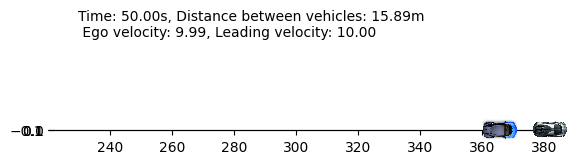

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

ego_velocity = y[:, 1]
leading_velocity = v_lead

# Assuming initial positions and constant time intervals for simplicity
dt = t[1] - t[0]  # time step
ego_position = np.cumsum(ego_velocity * dt)
leading_position = np.cumsum(leading_velocity * dt) + 30
distance_between_vehicles = leading_position - ego_position

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, max(leading_position) + 10)
ax.set_ylim(-0.1, 0.1)
ax.set_aspect(aspect=1.0)
# Load an image to use as the cursor (point)
ego_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Vehicle Control\Adaptive Cruise Control\assets\bugatti.jpg')  
leading_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Vehicle Control\Adaptive Cruise Control\assets\bugatti-black.jpg')  

# Create OffsetImage objects for the moving images
ego_vehicle_image = OffsetImage(ego_car_image, zoom=0.04)
leading_vehicle_image = OffsetImage(leading_car_image, zoom=0.04)

# Create AnnotationBbox objects for placing the images on the plot
ego_vehicle_ab = AnnotationBbox(ego_vehicle_image, (ego_position[0], 0), frameon=False)
leading_vehicle_ab = AnnotationBbox(leading_vehicle_image, (leading_position[0], 0), frameon=False)

# Add the AnnotationBbox objects to the axis
ax.add_artist(ego_vehicle_ab)
ax.add_artist(leading_vehicle_ab)

# Text for displaying time and distance information
distance_text = ax.text(0.05, 150.95, '', transform=ax.transAxes)

# Container for the AnnotationBbox objects
container = {
    'ego_vehicle_ab': ego_vehicle_ab,
    'leading_vehicle_ab': leading_vehicle_ab
}

def init():
    container['ego_vehicle_ab'].xy = (ego_position[0], 0)
    container['leading_vehicle_ab'].xy = (leading_position[0], 0)
    distance_text.set_text('')
    return container['ego_vehicle_ab'], container['leading_vehicle_ab'], distance_text

def update(frame):
    # Remove the previous AnnotationBbox objects
    container['ego_vehicle_ab'].remove()
    container['leading_vehicle_ab'].remove()

    # Create new AnnotationBbox objects with updated positions
    container['ego_vehicle_ab'] = AnnotationBbox(ego_vehicle_image, (ego_position[frame], 0), frameon=False)
    container['leading_vehicle_ab'] = AnnotationBbox(leading_vehicle_image, (leading_position[frame], 0), frameon=False)

    # Add the new AnnotationBbox objects to the axis
    ax.add_artist(container['ego_vehicle_ab'])
    ax.add_artist(container['leading_vehicle_ab'])

    # Update the text
    distance_text.set_text(f'Time: {t[frame]:.2f}s, Distance between vehicles: {distance_between_vehicles[frame]:.2f}m \n Ego velocity: {ego_velocity[frame]:.2f}, Leading velocity: {leading_velocity[frame]:.2f}')

    # Update the x-axis limits
    ax.set_xlim(leading_position[frame] - 160, leading_position[frame])

    return container['ego_vehicle_ab'], container['leading_vehicle_ab'], distance_text

ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, interval=100, blit=True, repeat=False)

# Save the animation
ani.save('vehicle_simulation.mp4', writer='ffmpeg')

'vehicle_simulation.mp4'


## Background:

### Comparison lemma:

The following comparison lemma enable us to convert the linear state feedback to a inequality constraints. 

Consider the scalar differential equation
$$
\dot{u}=f(t, u), \quad u\left(t_0\right)=u_0
$$
where $f(t, u)$ is continuous in $t$ and locally Lipschitz in $u$, for all $t \geq 0$ and all $u \in J \subset R$. Let $\left[t_0, T\right)$ ( $T$ could be infinity) be the maximal interval of existence of the solution $u(t)$, and suppose $u(t) \in J$ for all $t \in\left[t_0, T\right)$. Let $v(t)$ be a continuous function whose upper right hand derivative $D^{+} v(t)$ satisfies the differential inequality
$$
D^{+} v(t) \leq f(t, v(t)), \quad v\left(t_0\right) \leq u_0
$$
with $v(t) \in J$ for all $t \in\left[t_0, T\right)$. Then, $v(t) \leq u(t)$ for all $t \in\left[t_0, T\right)$.

**The comparison lemma suggests that you can bound the value of $v(t)$ by bounding its derivative compared to a reference function u(t).**

### CLF-CBF-QP Algorithm:

The square of the tracking error $h$ is the **control Lyapunov function (CLF)** that specify the **stability**. The function $B$ is the **control barrier function (CBF)** that specify the **safety** in the sense of **forward invariance**. The **CLF-CBF-QP** algorithm bridges the safety and stability via a single QP as we implemented in this task. 

For more details about the **CLF-CBF-QP** algorithm and the notion of **safety**, please refer to the following papers [1-3].  



## References:

[1] Ames, A.D., Grizzle, J.W. and Tabuada, P., 2014, December. Control barrier function based quadratic programs with application to adaptive cruise control. In 53rd IEEE Conference on Decision and Control (pp. 6271-6278). IEEE.

[2] Ames, A.D., Xu, X., Grizzle, J.W. and Tabuada, P., 2016. Control barrier function based quadratic programs for safety critical systems. IEEE Transactions on Automatic Control, 62(8), pp.3861-3876.

[3] Nguyen, Q. and Sreenath, K., 2016, July. Exponential control barrier functions for enforcing high relative-degree safety-critical constraints. In 2016 American Control Conference (ACC) (pp. 322-328). IEEE.

[4] https://en.wikipedia.org/wiki/Gr%C3%B6nwall%27s_inequality

[5] Bansal, S., Chen, M., Herbert, S. and Tomlin, C.J., 2017, December. Hamilton-jacobi reachability: A brief overview and recent advances. In 2017 IEEE 56th Annual Conference on Decision and Control (CDC) (pp. 2242-2253). IEEE.

[6] Vogel, K., 2003. A comparison of headway and time to collision as safety indicators. Accident analysis & prevention, 35(3), pp.427-433.